# 0. Required packages & Checking/Setting the device

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# run this cell when error happens: NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/big_data
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/big_data
'=0.20.1'				      GoogleNews-vectors-negative300.bin   test_trainer
 data					      lab2
'edit?resourcekey=0-wjGZdNAUop6WykTtMip30g'   SentimentAnalysis_NonSpark.ipynb


In [4]:
!pip install tensorflow
!pip install transformers[torch]
!pip install datasets
!pip install evaluate

In [5]:
# utilities
import re
import csv
import pickle
import collections
import numpy as np
import pandas as pd
from tqdm import tqdm

In [6]:
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [7]:
# nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from gensim.models.fasttext import load_facebook_vectors
from gensim.models import KeyedVectors

from tensorflow.keras.layers import Input, Embedding, Conv1D, Flatten, Dense, Dropout, concatenate, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Model, layers

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [9]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix

In [10]:
from datasets import Dataset
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import evaluate
from transformers import TrainingArguments, Trainer

In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available device: {}".format(device))

Available device: cuda:0


# 1. Data preprocessing

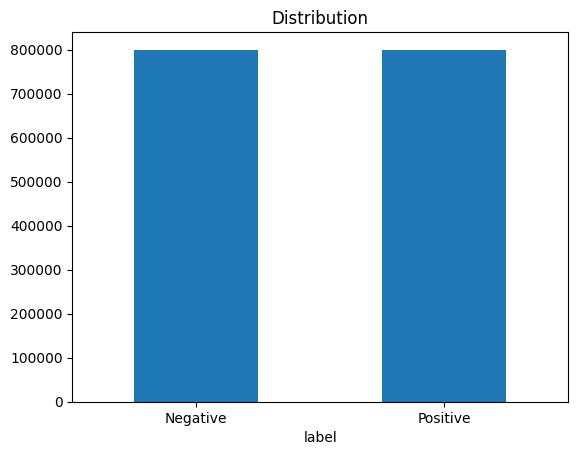

In [13]:
# read data
DATASET_COLUMNS  = ["label", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('data/data.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Remove unnecessary columns.
dataset = dataset[['label', 'text']]

# Replace label 4 with 1
dataset['label'] = dataset['label'].replace(4, 1)

# Plot the distribution.
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution', legend=False)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

# Store data in lists.
texts_list, labels_list = list(dataset['text']), list(dataset['label'])

In [14]:
dataset.tail()

,label,text
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1,happy #charitytuesday @theNSPCC @SparksCharity...


In [15]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bah" : "frustration",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "boooo" : "displeasure",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "fml" : "fuck my life",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "hun" : "honey",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "ott" : "over the top",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pedos" : "pedophile",
    "perma" : "permanent",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pmsl" : "pissing myself laughing",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w00t" : "joy",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
stopwords = {'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves'}

In [16]:
def preprocess(textdata, labeldata):
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    wordLemm = WordNetLemmatizer()

    processedText = []
    processedLabel = []
    for tweet, label in zip(textdata, labeldata):
        # Replace all URls with ' URL '
        tweet = re.sub(urlPattern,' URL ', tweet)
        # Replace @USERNAME to ' USER '.
        tweet = re.sub(userPattern,' USER ', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, " " + emojis[emoji] + " ")
        # Replace all abbreviations.
        for abbreviation in abbreviations.keys():
            tweet = tweet.replace(abbreviation, " " + abbreviations[abbreviation] + " ")
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Lower words.
        tweet = tweet.lower()

        tweetwords = ''
        for word in tweet.split():
            # Remove stop words
            if len(word)>1 and word not in stopwords:
                # Lemmatize the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word + ' ')
        if len(tweetwords) > 0:
            processedText.append(tweetwords)
            processedLabel.append(label)

    return processedText, processedLabel

In [17]:
%%time
processedtexts_list, processedlabels_list = preprocess(texts_list, labels_list)

CPU times: user 3min 38s, sys: 697 ms, total: 3min 38s
Wall time: 3min 38s


Word-Cloud for Negative tweets.

CPU times: user 18.1 s, sys: 575 ms, total: 18.7 s
Wall time: 18.6 s


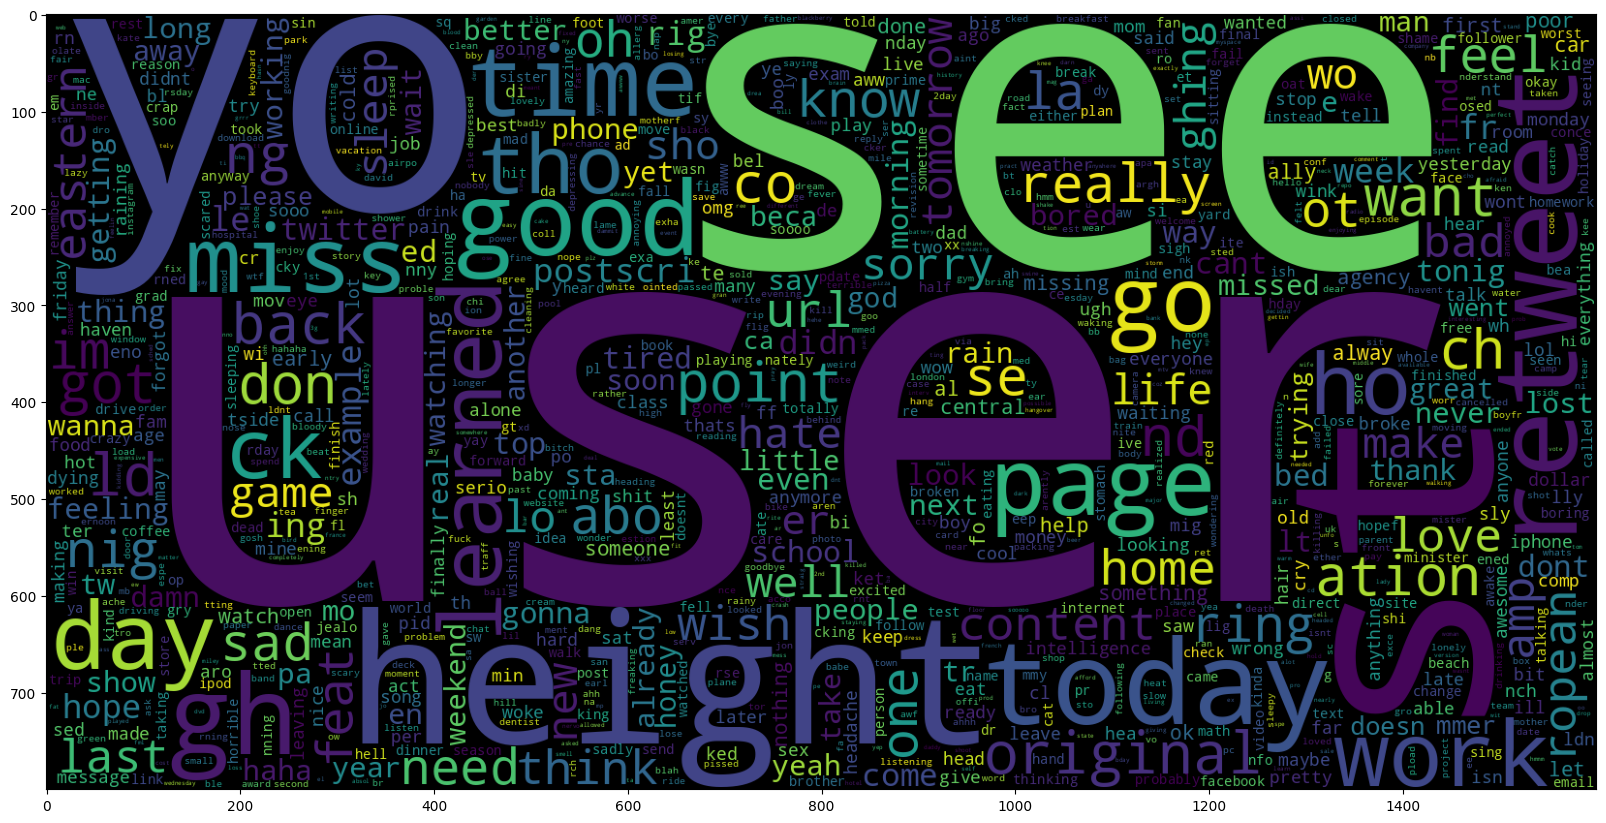

In [18]:
%%time
data_neg = processedtexts_list[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word-Cloud for Positive tweets.

CPU times: user 17.8 s, sys: 508 ms, total: 18.3 s
Wall time: 18.2 s


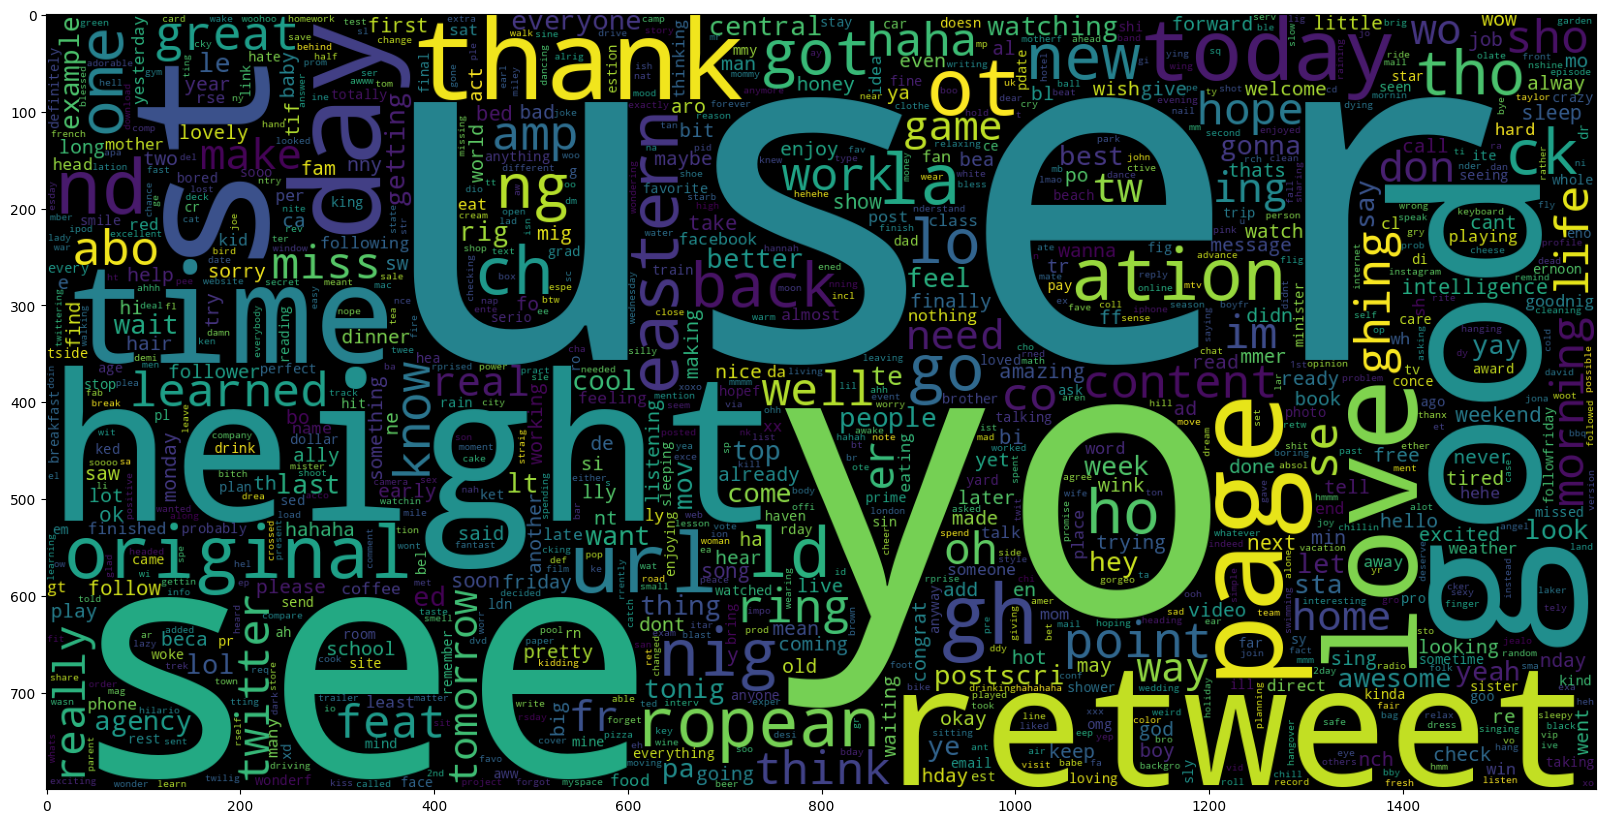

In [19]:
%%time
data_pos = processedtexts_list[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [20]:
%%time
cleaned_data = {'text': processedtexts_list, 'label': processedlabels_list}
cleaned_data_df = pd.DataFrame(cleaned_data)
path_to_save = 'data/cleaned_data.csv'
cleaned_data_df.to_csv(path_to_save, index=False)
print("Save cleaned data to " + path_to_save)
df_data = cleaned_data_df

Save cleaned data to data/cleaned_data.csv
CPU times: user 3.59 s, sys: 86.4 ms, total: 3.68 s
Wall time: 3.96 s


In [21]:
df_data.groupby('label').count()

,text
label,
0,799818
1,799811


In [22]:
cleaned_data_df

,text,label
0,user url awww mmer yo sho lda got david carr t...,0
1,postscri point et pdate facebook texting mig h...,0
2,user dived many time ball managed save 50 rest...,0
3,whole body feel itchy like fire,0
4,user no not behaving mad beca se see yo over,0
...,...,...
1599624,st woke no school best feeling ever,1
1599625,thewdb com cool hear old walt interv w url,1
1599626,yo ready yo mojo makeover ask detail,1
1599627,page see ation 38th bi retweet hday boo alll t...,1


# 2. Word vectorization & Word embedding & Partition data

For classic ML classifiers, we use tf-idf to vector our texts.

In [23]:
%%time
X_train, X_test, y_train, y_test = train_test_split(processedtexts_list, processedlabels_list, test_size = 0.1, random_state = 0)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

CPU times: user 1min 17s, sys: 1.61 s, total: 1min 19s
Wall time: 1min 19s


For transformer, it will be tokenized by pre-trained model later.

# 3. Experiments of classic ML classifiers

In [22]:
sentiments = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
def evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = sentiments, yticklabels = sentiments)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Multinomial Naive Bayes(MultinomialNB)

              precision    recall  f1-score   support

           0       0.78      0.79      0.78    159815
           1       0.79      0.78      0.78    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

CPU times: user 1.69 s, sys: 51.1 ms, total: 1.74 s
Wall time: 1.69 s


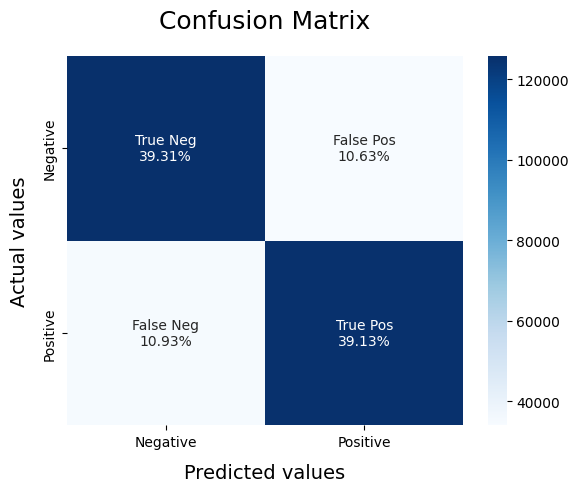

In [26]:
%%time
classifier_mnb = MultinomialNB()
classifier_mnb.fit(X_train, y_train)
evaluate(classifier_mnb)

Bernoulli Naive Bayes (BernoulliNB)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78    159815
           1       0.78      0.78      0.78    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

CPU times: user 1.86 s, sys: 110 ms, total: 1.97 s
Wall time: 1.91 s


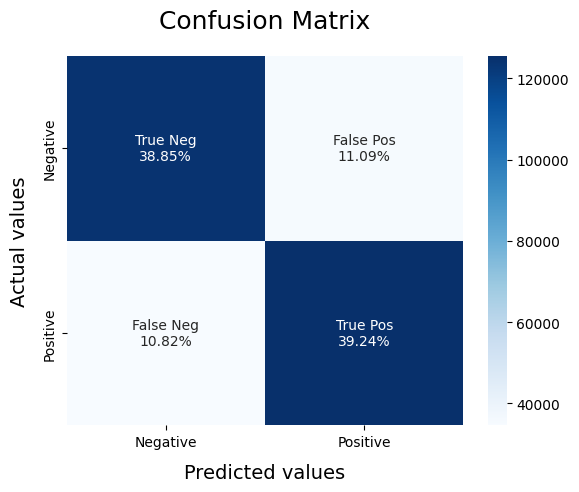

In [23]:
%%time
classifier_bnb = BernoulliNB(alpha = 2)
classifier_bnb.fit(X_train, y_train)
evaluate(classifier_bnb)

Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159815
           1       0.80      0.82      0.81    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

CPU times: user 3.31 s, sys: 1.25 s, total: 4.55 s
Wall time: 3min 29s


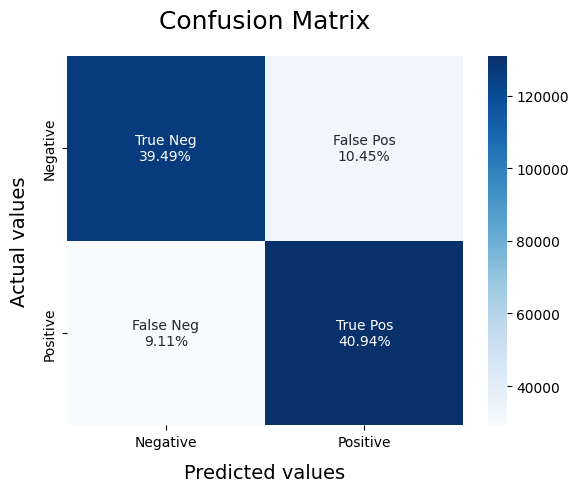

In [24]:
%%time
classifier_lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
classifier_lr.fit(X_train, y_train)
evaluate(classifier_lr)

Random Forest

              precision    recall  f1-score   support

           0       0.63      0.03      0.07    159815
           1       0.50      0.98      0.67    160185

    accuracy                           0.51    320000
   macro avg       0.57      0.51      0.37    320000
weighted avg       0.57      0.51      0.37    320000

CPU times: user 2.36 s, sys: 268 ms, total: 2.63 s
Wall time: 2.54 s


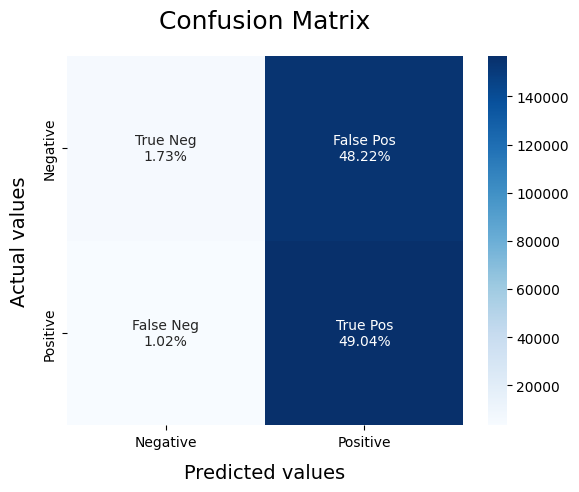

In [27]:
%%time
classifier_rf = RandomForestClassifier(n_estimators=2, max_depth=5, random_state=0)
classifier_rf.fit(X_train, y_train)
evaluate(classifier_rf)

LinearSVC Model

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159815
           1       0.78      0.80      0.79    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

CPU times: user 35 s, sys: 305 ms, total: 35.3 s
Wall time: 35 s


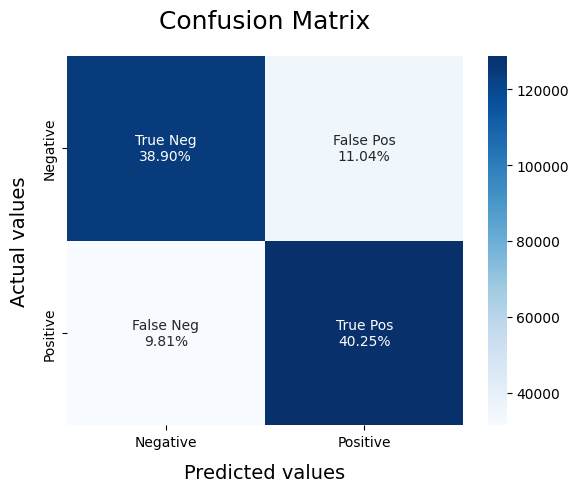

In [25]:
%%time
classifier_svc = LinearSVC()
classifier_svc.fit(X_train, y_train)
evaluate(classifier_svc)

# 4. Experiments of BERT

Pre-trained Transformer (bert)

In [12]:
%%time
df_dataset = pd.read_csv('data/cleaned_data.csv')
def gen():
    for row in df_dataset.itertuples():
        yield {"text": row[1], "label": row[2]}
dataset = Dataset.from_generator(gen)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

splited_dataset = tokenized_datasets.train_test_split(test_size=0.1)
train_dataset, test_dataset = splited_dataset['train'], splited_dataset['test']

CPU times: user 6.02 s, sys: 349 ms, total: 6.37 s
Wall time: 6.38 s


In [ ]:
%%time
import accelerate
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=56,  # batch size per device during training
    per_device_eval_batch_size=128,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    evaluation_strategy="steps",
    eval_steps=3000,
    resume_from_checkpoint="test_trainer"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
3000,0.456400,0.441659,0.795015
6000,0.438400,0.444265,0.796891
9000,0.423500,0.419471,0.807487
12000,0.416400,0.412438,0.809756
15000,0.410800,0.407387,0.814044


Step,Training Loss,Validation Loss,Accuracy
3000,0.456400,0.441659,0.795015
6000,0.438400,0.444265,0.796891
9000,0.423500,0.419471,0.807487
12000,0.416400,0.412438,0.809756
15000,0.410800,0.407387,0.814044


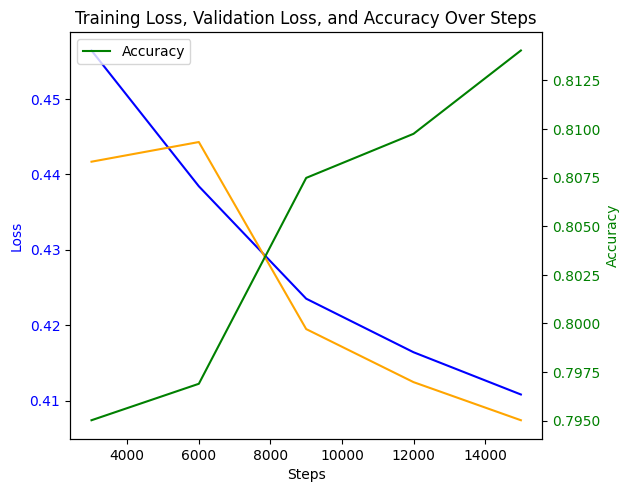

In [ ]:
import matplotlib.pyplot as plt

steps = [3000, 6000, 9000, 12000, 15000]
training_loss = [0.456400, 0.438400, 0.423500, 0.416400, 0.410800]
validation_loss = [0.441659, 0.444265, 0.419471, 0.412438, 0.407387]
accuracy = [0.795015, 0.796891, 0.807487, 0.809756, 0.814044]

fig, ax1 = plt.subplots()

color_loss = 'blue'
color_accuracy = 'green'

ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss', color=color_loss)
ax1.plot(steps, training_loss, label='Training Loss', color=color_loss)
ax1.plot(steps, validation_loss, label='Validation Loss', color='orange')
ax1.tick_params(axis='y', labelcolor=color_loss)

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color=color_accuracy)
ax2.plot(steps, accuracy, label='Accuracy', color=color_accuracy)
ax2.tick_params(axis='y', labelcolor=color_accuracy)

fig.tight_layout()
plt.legend()
plt.title('Training Loss, Validation Loss, and Accuracy Over Steps')
plt.show()


# 5. Results comparison

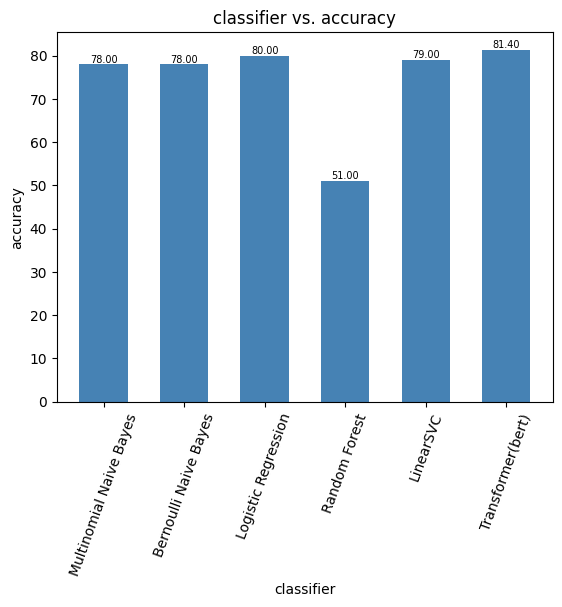

<Figure size 640x480 with 0 Axes>

In [ ]:
cls_acc = {
    'Multinomial Naive Bayes' :   78,
    'Bernoulli Naive Bayes'           :   78,
    'Logistic Regression'   :   80,
    'Random Forest'         :   51,
    'LinearSVC'                   :   79,
    'Transformer(bert)'           :   81.40,
}
cls, accs = [], []
for key, value in cls_acc.items():
    cls.append(key)
    accs.append(value)

# generate bar graph
fig = plt.figure()
X, Y = cls, accs
plt.bar(X, Y, 0.6, color="steelblue")
# show scores
for a,b in zip(X,Y):
    plt.text(a,b,'%.2f'%b,ha='center',va='bottom',fontsize=7)
plt.xlabel("classifier")
plt.xticks(rotation=70)
plt.ylabel("accuracy")
plt.title("classifier vs. accuracy")
plt.show()
plt.savefig("classification accuracies.jpg")